In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from utils_multi import *

sp500 = pd.read_csv('data/SP500.csv')
sp500 = process_data(sp500)

kospi = pd.read_csv('data/KOSPI200.csv')
kospi = process_data(kospi)

In [2]:
var_confidence = 0.01

In [3]:
kospi_return = kospi['Change']
sp500_return = sp500['Change']

daily_returns = pd.merge(kospi_return, sp500_return, left_index=True, right_index=True)
daily_returns.columns = ['kospi', 'sp500']

In [4]:
sp500 = get_historical_var(sp500, 400, var_confidence, 'sp500')
kospi = get_historical_var(kospi, 400, var_confidence, 'kospi')

In [5]:
sp500 = set_signal(sp500, 'sp500')
kospi = set_signal(kospi, 'kospi')

In [6]:
sp500['Change_sp500'] = sp500['Change']
kospi['Change_kospi'] = kospi['Change']

In [7]:
# dc = daily_returns.cov()
# cov = dc * len(daily_returns)
# mean = daily_returns.mean() * len(daily_returns)
# lev = inv(cov).dot(mean)

# kc = pd.Series(lev, index = daily_returns.columns)
# kc

In [8]:
def calculate_portfolio_weights(daily_returns, window=400):
    
    # 포트폴리오 최적화를 위한 이동 창 적용
    weights = []
    for i in range(len(daily_returns) - window + 1):
        # 이동 창에 대해 공분산 행렬과 평균 수익률 벡터 계산
        window_returns = daily_returns.iloc[i:i+window]
        covariance_matrix = window_returns.cov()
        mean_returns = window_returns.mean()
        
        # 포트폴리오 가중치 계산
        cov = covariance_matrix * len(window_returns)
        mean = mean_returns * len(window_returns)
        lev = inv(cov).dot(mean)
        
        # 가중치를 리스트에 추가
        weights.append(lev)
    
    # 계산된 가중치로 Pandas Series 생성
    weights_df = pd.DataFrame(weights, columns=daily_returns.columns,
                              index=daily_returns.index[window-1:])

    return weights_df

# 함수 사용 예시
portfolio_weights = calculate_portfolio_weights(daily_returns, window=400)

In [9]:
portfolio_weights

,kospi,sp500
Date,,
08/28/2007,3.362058,6.500522
08/29/2007,3.309626,6.622743
08/30/2007,3.364435,6.298273
08/31/2007,3.682524,6.626284
09/04/2007,3.461549,6.700462
...,...,...
03/14/2024,2.986925,4.985902
03/15/2024,2.440752,4.525379
03/18/2024,2.559995,4.736246


In [10]:
portfolio_weights['capped_kospi'] = portfolio_weights['kospi'].apply(lambda x: calculate_capped_kelly(x, 3))
portfolio_weights['capped_sp500'] = portfolio_weights['sp500'].apply(lambda x: calculate_capped_kelly(x, 3))

In [11]:
kospi.tail(3)

,Price,Open,High,Low,Change %,Change,VaR_kospi,trix,buy_kospi,sell_kospi,Change_kospi
Date,,,,,,,,,,,
03/18/2024,361.31,360.74,361.77,358.53,0.53%,0.0053,-0.0258,0.140155,False,False,0.0053
03/19/2024,357.33,359.03,359.07,355.51,-1.10%,-0.0110,-0.0258,0.066633,False,False,-0.0110
03/20/2024,363.32,361.07,363.58,359.93,1.68%,0.0168,-0.0258,0.059858,False,False,0.0168


In [12]:
sp500.tail(3)

,Price,Open,High,Low,Change %,Change,VaR_sp500,trix,buy_sp500,sell_sp500,Change_sp500
Date,,,,,,,,,,,
05/04/2024,5161.5,5161.50,5161.50,5161.50,0.13%,0.0013,-0.0174,0.077108,False,False,0.0013
05/06/2024,5206.5,5166.75,5207.75,5155.75,0.87%,0.0087,-0.0174,0.150209,False,False,0.0087
05/07/2024,5221.5,5206.25,5223.50,5202.25,0.29%,0.0029,-0.0174,0.215193,False,False,0.0029


In [13]:
portfolio_weights.tail(3)

,kospi,sp500,capped_kospi,capped_sp500
Date,,,,
03/18/2024,2.559995,4.736246,2.559995,3.0
03/19/2024,2.389722,5.041899,2.389722,3.0
03/20/2024,2.604126,4.877413,2.604126,3.0


In [14]:
portfolio = pd.concat([portfolio_weights, sp500[['buy_sp500', 'sell_sp500', 'VaR_sp500', 'Change_sp500']], kospi[['buy_kospi', 'sell_kospi', 'VaR_kospi', 'Change_kospi']]], axis=1)

In [15]:
# rf 추가
rf = pd.read_csv('data/rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
portfolio = portfolio.join(rf)

In [16]:
portfolio = portfolio.dropna()

In [17]:
index_location = portfolio.index.get_loc('01/08/2009')
portfolio = portfolio.iloc[index_location+1:]

In [32]:
portfolio

,kospi,sp500,capped_kospi,capped_sp500,buy_sp500,sell_sp500,VaR_sp500,Change_sp500,buy_kospi,sell_kospi,VaR_kospi,Change_kospi,rf,portfolio,equity_sp500,equity_kospi,cash
Date,,,,,,,,,,,,,,,,,
01/09/2009,-0.543767,-1.404700,0.000000,0.0,False,False,-0.0788,-0.0234,False,False,-0.0720,-0.0228,0.000097,1.000000,0.0,0.0,1.000000
01/12/2009,-0.627106,-1.522289,0.000000,0.0,True,False,-0.0788,-0.0198,False,False,-0.0720,-0.0205,0.000093,1.000093,0.0,0.0,1.000093
01/13/2009,-0.585230,-1.518453,0.000000,0.0,False,False,-0.0788,0.0006,False,False,-0.0720,0.0095,0.000091,1.000183,0.0,0.0,1.000183
01/14/2009,-0.419728,-1.715890,0.000000,0.0,False,False,-0.0788,-0.0331,False,False,-0.0720,0.0134,0.000091,1.000274,0.0,0.0,1.000274
01/15/2009,-0.763183,-1.664785,0.000000,0.0,False,False,-0.0788,-0.0006,True,False,-0.0720,-0.0612,0.000093,1.000368,0.0,0.0,1.000368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03/14/2024,2.986925,4.985902,2.986925,3.0,False,False,-0.0229,-0.0028,False,False,-0.0258,0.0100,0.000087,0.007696,0.0,0.0,0.007696
03/15/2024,2.440752,4.525379,2.440752,3.0,False,False,-0.0229,-0.0068,False,False,-0.0258,-0.0199,0.000087,0.007696,0.0,0.0,0.007696
03/18/2024,2.559995,4.736246,2.559995,3.0,False,False,-0.0229,0.0062,False,False,-0.0258,0.0053,0.000088,0.007697,0.0,0.0,0.007697


In [35]:
portfolio['VaR_kospi'] = portfolio.apply(lambda row: 0 if row['VaR_kospi'] > row['Change_kospi'] else row['capped_kospi'], axis=1)
portfolio['VaR_sp500'] = portfolio.apply(lambda row: 0 if row['VaR_sp500'] > row['Change_sp500'] else row['capped_sp500'], axis=1)


In [36]:
def get_cumulative_trix_returns(df):
    portfolio = np.zeros(len(df))
    equity = np.zeros(len(df))
    equity2 = np.zeros(len(df))
    cash = np.zeros(len(df))
    latest_kospi = df.iloc[0]['capped_kospi']
    latest_sp500 = df.iloc[0]['capped_kospi']

    for i, _row in enumerate(df.iterrows()):
        row = _row[1]
        if i == 0:
            portfolio[0] = 1
            cash[0] = 1 - row['capped_sp500'] - row['capped_kospi']
            equity[0] = row['capped_sp500']
            equity2[0] = row['capped_kospi']
        else:
            portfolio[i] = equity[i-1] * (1 + row['Change_sp500']) + equity2[i-1] * (1+row['Change_kospi']) + cash[i-1] * (1 + row['rf'])
            if row['buy_kospi']:
                if portfolio[i] < 0:
                    equity[i] = equity[i-1] * (1 + row['Change_sp500']) 
                    equity2[i] = equity2[i-1] * (1 + row['Change_kospi']) 
                    cash[i] = cash[i-1] * (1 + row['rf']) 
                else:
                    if row['buy_sp500'] == False:
                        equity[i] = equity[i-1] * (1 + row['Change_sp500'])
                        equity2[i] = portfolio[i] * row['capped_kospi'] 
                        cash[i] = portfolio[i] * (1 - row['capped_kospi'] - latest_sp500)   
                        latest_kospi = row['capped_kospi']     
                    else:
                        equity[i] = portfolio[i] * row['capped_sp500'] 
                        equity2[i] = portfolio[i] * row['capped_kospi'] 
                        cash[i] = portfolio[i] * (1 - row['capped_kospi'] - row['capped_sp500'])   
                        latest_kospi = row['capped_kospi']    
                        latest_sp500 = row['capped_sp500']  
            elif row['sell_kospi']:
                latest_kospi = 0
                if row['sell_sp500']:
                    latest_sp500 = 0
                    equity[i] = 0
                    equity2[i] = 0
                    cash[i] = portfolio[i]
                else:
                    equity[i] = equity[i-1] * (1 + row['Change_sp500']) 
                    equity2[i] = 0
                    cash[i] = cash[i-1] + equity2[i-1]
            else:
                if row['buy_sp500']:
                    equity[i] = portfolio[i] * row['capped_sp500'] 
                    equity2[i] = equity2[i-1] * (1 + row['Change_kospi'])
                    cash[i] = portfolio[i] * (1 - row['capped_sp500'] - latest_kospi)   
                    latest_sp500 = row['capped_sp500']  
                elif row['sell_sp500']:
                    latest_sp500 = 0
                    equity[i] = 0
                    equity2[i] = equity2[i-1] * (1 + row['Change_kospi']) 
                    cash[i] = cash[i-1] + equity[i-1]
                else:
                    equity[i] = equity[i-1] * (1 + row['Change_sp500'])
                    equity2[i] = equity2[i-1] * (1 + row['Change_kospi'])
                    cash[i] = cash[i-1] * (1 + row['rf'])
    df.loc[:, 'portfolio'] = portfolio
    df.loc[:, 'equity_sp500'] = equity
    df.loc[:, 'equity_kospi'] = equity2
    df.loc[:, 'cash'] = cash

    return df

In [37]:
temp = get_cumulative_trix_returns(portfolio)

In [38]:
temp.to_csv('확인.csv')

<Axes: xlabel='Date'>

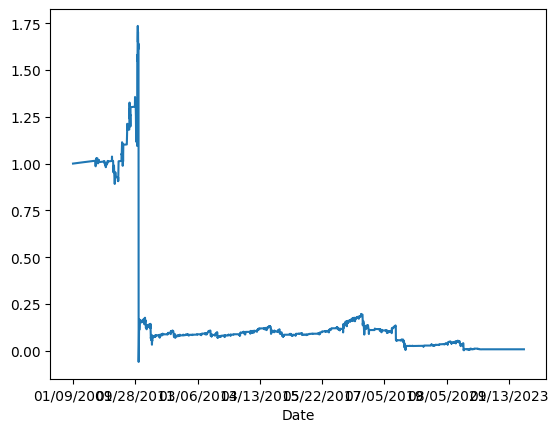

In [39]:
temp['portfolio'].plot()